In [202]:
import MetaTrader5 as mt5
import pandas as pd
from backtesting import Backtest
import ta
import datetime
import json
import numpy as np
import pandas as pd
import ta
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import metrics

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 20)

In [116]:
from backtesting import Strategy


class IFRBacktest(Strategy):
    def init(self):
        self.copy = self.data

    def next(self):
        price = self.data.Close[-2]
        rsi = self.data.RSI[-2]
        sma = self.data.SMA[-2]
        if not self.position:
            if rsi < 10:
                self.buy()
                #print("OpenBuy", self.data.index[-1])
            elif rsi > 90:
                self.sell()
                #print("OpenSell",self.data.index[-1])
        else:
            if self.position.is_long and (price > sma):
                self.position.close()
                #print("CloseBuy",self.data.index[-1])
            elif self.position.is_short and (price < sma):
                self.position.close()
                #print("CloseSell",self.data.index[-1])

In [3]:
print(mt5.initialize(path="C:\Program Files\MetaTrader 5\\terminal64.exe", login=50498337, password="Pkvxcav9"))

True


In [89]:
timeframes = {'M1': mt5.TIMEFRAME_M1, 'M2': mt5.TIMEFRAME_M2, 'M5': mt5.TIMEFRAME_M5, 'M15': mt5.TIMEFRAME_M15,
              'M30': mt5.TIMEFRAME_M30, 'H1': mt5.TIMEFRAME_H1, 'H4': mt5.TIMEFRAME_H4, 'D1': mt5.TIMEFRAME_D1}


def getBacktest(data):
    
    dateFrom = datetime.datetime.strptime(data['dateFrom'], '%Y-%m-%d %H:%M')
    dateTo = datetime.datetime.strptime(data['dateTo'], '%Y-%m-%d %H:%M')

    df = pd.DataFrame(mt5.copy_rates_range(data['symbol'], timeframes[data['timeframe']], dateFrom, dateTo))
    df.rename(columns={'time': 'Date', 'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close'}, inplace=True)
    df['Date'] = pd.to_datetime(df['Date'], unit='s')
    df.set_index('Date', inplace=True)

    if data['name'] == "IFR2":
        df['RSI'] = ta.momentum.RSIIndicator(df['Close'], data['params']['period'], True).rsi()
        df['SMA'] = ta.trend.SMAIndicator(df['Close'], 5, True).sma_indicator()
        df = df[2:]
        bt = Backtest(df, IFRBacktest, commission=0, exclusive_orders=False)
        stats = bt.run().to_json()
        #stats = bt.run()
        #bt.plot()
        return stats, df

    elif data['name'] == "Cross Average":
        df['mFast'] = ta.trend.SMAIndicator(df['Close'], data['params']['periodFast'], True).sma_indicator()
        df['mSlow'] = ta.trend.SMAIndicator(df['Close'], data['params']['periodSlow'], True).sma_indicator()
        df = df[2:]
        bt = Backtest(df, CrossAverageBacktest, commission=0, exclusive_orders=False)
        stats = bt.run().to_json()
        return stats, df
    


In [206]:
config = {
"name" : "IFR2",
"nickName" :"TRYT",
"symbol": "GBPUSD",
"timeframe":"H4",
"lot":0.01,
"magicNumber" : 2424,
"mode" : "Comprado e Vendido",
"params": {
        "period": 3
    },
"dateFrom": "2017-01-01 08:00",
"dateTo": "2021-01-01 00:00"
}

In [207]:
dct, data = getBacktest(config)
dct = json.loads(dct)['_trades']
df = pd.DataFrame.from_dict(dct, orient='index')

df['EntryTime'] = pd.to_datetime(df['EntryTime'], unit="ms")
df['ExitTime'] = pd.to_datetime(df['ExitTime'], unit="ms")
df['Duration'] = pd.to_datetime(df['Duration'], unit="ms")
df['Duration'] = [x.time() for x in df['Duration']]
df['RSI'] = [data.RSI.iloc[x -1] for x in df.EntryBar]
df['SMA'] = [data.SMA.iloc[x -1] for x in df.EntryBar]
df['Open'] = [data.Open.iloc[x -1] for x in df.EntryBar]
df['High'] = [data.High.iloc[x -1] for x in df.EntryBar]
df['Low'] = [data.Low.iloc[x -1] for x in df.EntryBar]
df['Close'] = [data.Close.iloc[x -1] for x in df.EntryBar]
df['Return'] =   df['Close'].pct_change() # Retorno percentual
df['Returnshift'] = df['Return'].shift(-1)
df['Alta/Baixa'] = [1 if x >= 0 else 0 for x in df['Return']] # dia de alta ou de baixa

df['A'] = df['High'] / df['Low']   # Razão entre a máxima e mínima do candle

df['B'] = (abs(df['Close'] - df['Open'])) / (df['High'] - df['Low'])  # Razão entre o corpo e a amplitude do candle

sombra1 = (df['High'] - df['Close']) / (df['Open'] - df['Low'])
sombra2 = (df['High'] - df['Open']) / (df['Close'] - df['Low'])

df['C'] = [sombra1.loc[x] if df.loc[x, 'Alta/Baixa'] == 1 else sombra2.loc[x] for x in df.index] # Razão entre a sombra superior e inferior

df['D'] = df['Close'] / df['Close'].shift(1) # Razão entre o fechamento de Hoje e o de x dias anteriores


df['H'] = df['Return'].rolling(5).std() # Volatildiade dos últimos x dias

df['I'] = df['H'].rolling(5).sum() # Volatildiade acumulada dos últimos x dias



df['Pips'] = df['ExitPrice'] -  df['EntryPrice']
df['CumPips'] = df['Pips'].cumsum()
df['alvo'] = df['Pips'] > 0
df['alvo'] = df['alvo'].astype(int)
df.dropna(inplace=True)
df


,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration,RSI,SMA,Open,High,Low,Close,Return,Returnshift,Alta/Baixa,A,B,C,D,H,I,Pips,CumPips,alvo
9,8217,158,160,1.23666,1.25059,114.46281,0.011264,2017-02-07 16:00:00,2017-02-08 00:00:00,08:00:00,10.985377,1.242792,1.23656,1.23847,1.23502,1.23667,-0.009912,0.015137,0,1.002793,0.031884,1.157576,0.990088,0.010759,0.054647,0.01393,-0.00202,1
10,-8187,232,236,1.25512,1.25487,2.04675,0.000199,2017-02-24 00:00:00,2017-02-24 16:00:00,16:00:00,93.307041,1.250456,1.25439,1.25580,1.25379,1.25539,0.015137,-0.009511,1,1.001603,0.497512,0.683333,1.015137,0.012667,0.056556,-0.00025,-0.00227,0
11,8266,240,244,1.24344,1.24408,5.29024,0.000515,2017-02-27 08:00:00,2017-02-28 00:00:00,16:00:00,24.606605,1.246408,1.24229,1.24345,1.24112,1.24345,-0.009511,-0.003780,0,1.001877,0.497854,0.497854,0.990489,0.011187,0.056908,0.00064,-0.00163,1
12,8301,251,261,1.23875,1.22646,-102.01929,-0.009921,2017-03-01 04:00:00,2017-03-02 20:00:00,16:00:00,24.419442,1.240404,1.23745,1.23892,1.23628,1.23875,-0.003780,-0.012254,0,1.002135,0.492424,0.595142,0.996220,0.011032,0.056798,-0.01229,-0.01392,0
13,8321,266,268,1.22357,1.22787,35.78030,0.003514,2017-03-03 16:00:00,2017-03-06 00:00:00,08:00:00,25.859550,1.225154,1.22287,1.22471,1.22137,1.22357,-0.012254,-0.000106,0,1.002735,0.209581,0.836364,0.987746,0.011177,0.056822,0.00430,-0.00962,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333,-7527,6128,6130,1.34601,1.33966,47.79645,0.004718,2020-12-09 16:00:00,2020-12-10 00:00:00,08:00:00,95.852284,1.340170,1.34466,1.34784,1.34384,1.34601,0.010381,-0.017333,1,1.002977,0.337500,2.231707,1.010381,0.009510,0.032470,-0.00635,-0.11265,0
334,7696,6141,6144,1.32268,1.33232,74.18944,0.007288,2020-12-11 20:00:00,2020-12-14 08:00:00,12:00:00,41.758459,1.324950,1.31810,1.32553,1.31758,1.32268,-0.017333,0.027036,0,1.006034,0.576101,1.456863,0.982667,0.012893,0.040562,0.00964,-0.10301,1
335,-7548,6166,6167,1.35856,1.35553,22.87044,0.002230,2020-12-18 00:00:00,2020-12-18 04:00:00,04:00:00,57.206100,1.358598,1.36080,1.36206,1.35447,1.35844,0.027036,-0.026825,1,1.005604,0.310935,0.571880,1.027036,0.018264,0.054909,-0.00303,-0.10604,0
336,7774,6175,6178,1.32202,1.34643,189.76334,0.018464,2020-12-21 12:00:00,2020-12-22 00:00:00,12:00:00,3.682145,1.339822,1.33664,1.33664,1.32141,1.32200,-0.026825,0.021006,0,1.011526,0.961261,0.000000,0.973175,0.021993,0.071938,0.02441,-0.08163,1


In [181]:
df.EntryTime.describe()

<ipython-input-181-2e61c16dd024>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.EntryTime.describe()


count                      78
unique                     78
top       2020-10-12 00:00:00
freq                        1
first     2020-02-04 00:00:00
last      2020-12-24 00:00:00
Name: EntryTime, dtype: object

<AxesSubplot:>

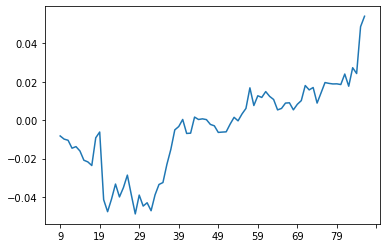

In [182]:
df.CumPips.plot()

In [ ]:
def ml(variaveis):
    X = df[variaveis]
    y = df['alvo']
    
    X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.3, random_state=42)
    
    clf = VotingClassifier([('Rfor',RandomForestClassifier(n_estimators=10000, n_jobs=-1, random_state=0)),
                           ('LogR',LogisticRegression(random_state=0)),
                           ('knn',KNeighborsClassifier(n_neighbors = 5))])
    clf.fit(X_treino, y_treino)
    confidence = clf.score(X_teste,y_teste)
    print('Acurácia',confidence)
    prediction = clf.predict(X_teste)
    return confidence

In [210]:
#variaveis = ['RSI', 'SMA', 'A', 'B', 'C', 'D', 'H', 'I']
variaveis = ['Alta/Baixa']
X = df[variaveis]
y = df['alvo']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [209]:
random = RandomForestClassifier()
random = random.fit(X_train,y_train)
resultadoRandom = random.predict(X_test)
print(metrics.classification_report(y_test, resultadoRandom))

              precision    recall  f1-score   support

           0       0.46      0.55      0.50        49
           1       0.45      0.36      0.40        50

    accuracy                           0.45        99
   macro avg       0.45      0.46      0.45        99
weighted avg       0.45      0.45      0.45        99

